In [ ]:
import argparse
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tifffile

# check if in a jupyter notebook
try:
    cfg = get_ipython().config
    in_notebook = True
except NameError:
    in_notebook = False

# Get the current working directory
cwd = pathlib.Path.cwd()

if (cwd / ".git").is_dir():
    root_dir = cwd

else:
    root_dir = None
    for parent in cwd.parents:
        if (parent / ".git").is_dir():
            root_dir = parent
            break

# Check if a Git root directory was found
if root_dir is None:
    raise FileNotFoundError("No Git root directory found.")

In [ ]:
if not in_notebook:
    print("Running as script")
    # set up arg parser
    parser = argparse.ArgumentParser(description="Segment the nuclei of a tiff image")

    parser.add_argument(
        "--patient",
        type=str,
        help="Patient ID",
    )

    parser.add_argument(
        "--well_fov",
        type=str,
        help="Path to the input directory containing the tiff images",
    )

    args = parser.parse_args()
    well_fov = args.well_fov
    patient = args.patient

else:
    print("Running in a notebook")
    well_fov = "C4-2"
    patient = "NF0014"


input_dir = pathlib.Path(
    f"{root_dir}/data/{patient}/zstack_images/{well_fov}/"
).resolve(strict=True)
mask_input_dir = pathlib.Path(
    f"{root_dir}/data/{patient}/segmentation_masks/{well_fov}"
).resolve(strict=True)
output_path = pathlib.Path(
    f"{root_dir}/data/{patient}/segmentation_masks/{well_fov}"
).resolve()
output_path.mkdir(parents=True, exist_ok=True)
output_file_path = pathlib.Path(output_path / "cytoplasm_mask.tiff").resolve()

Running in a notebook


In [ ]:
# get all the masks
nuclei_masks_path = pathlib.Path(
    mask_input_dir / "nuclei_masks_reconstructed_corrected.tiff"
).resolve(strict=True)
cell_masks_path = pathlib.Path(mask_input_dir / "cell_masks_watershed.tiff").resolve(
    strict=True
)

nuclei_masks = tifffile.imread(nuclei_masks_path)
cell_masks = tifffile.imread(cell_masks_path)

In [4]:
cytoplasm_masks = np.zeros_like(cell_masks)
# filter masks that are not the background
for z_slice_index in range(nuclei_masks.shape[0]):
    nuclei_slice_mask = nuclei_masks[z_slice_index]
    cell_slice_mask = cell_masks[z_slice_index]
    cytoplasm_mask = cell_slice_mask.copy()
    cytoplasm_mask[nuclei_slice_mask > 0] = 0
    cytoplasm_masks[z_slice_index] = cytoplasm_mask

In [5]:
tifffile.imwrite(output_file_path, cytoplasm_masks)

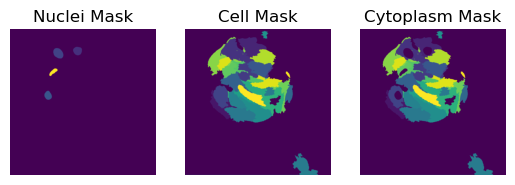

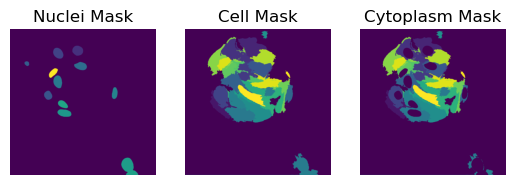

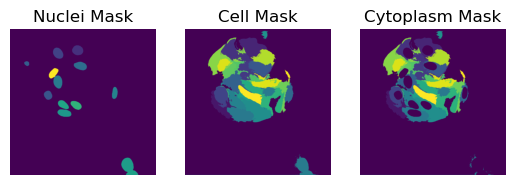

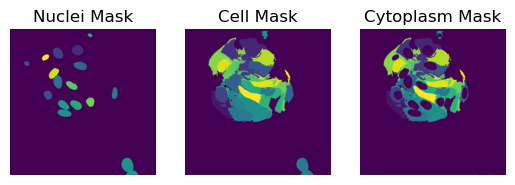

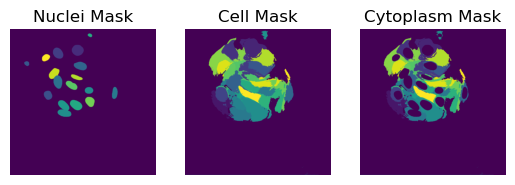

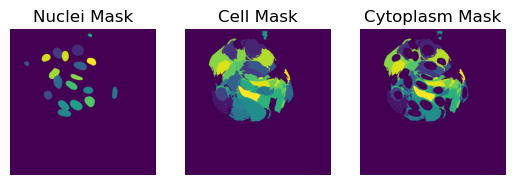

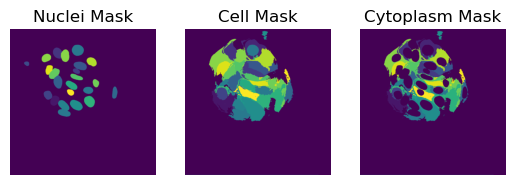

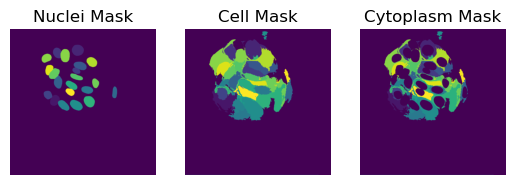

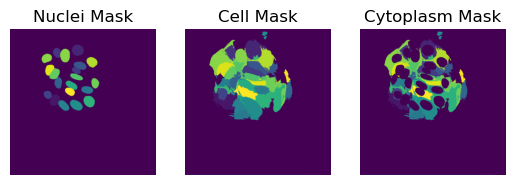

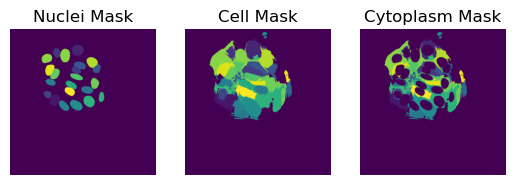

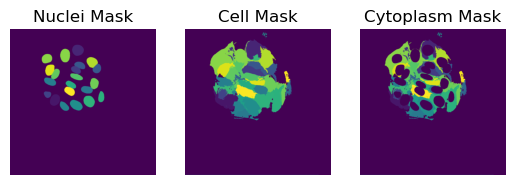

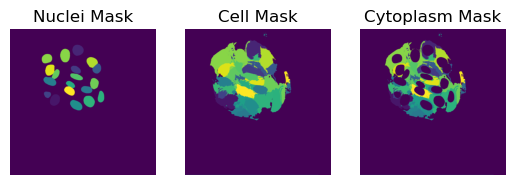

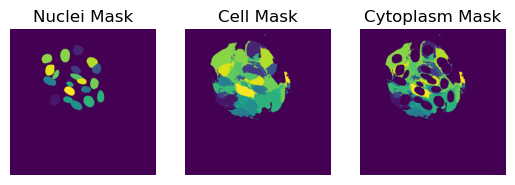

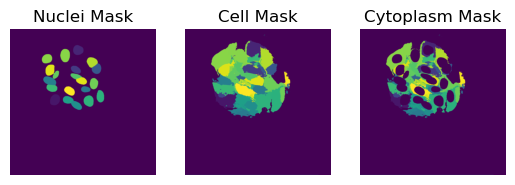

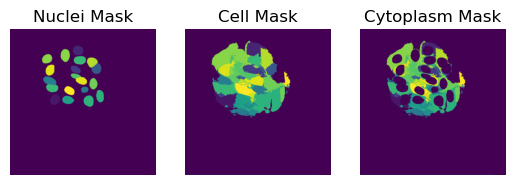

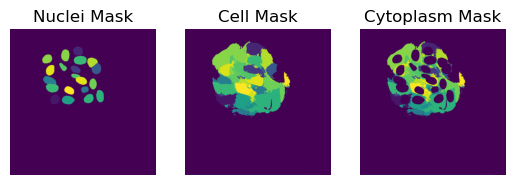

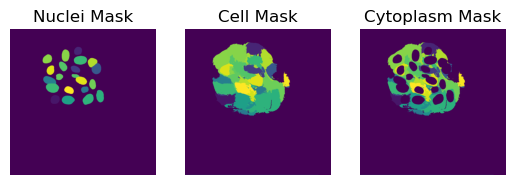

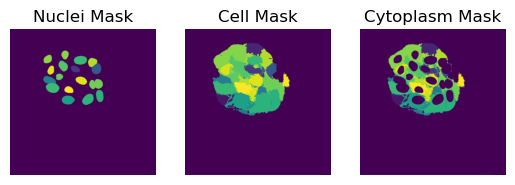

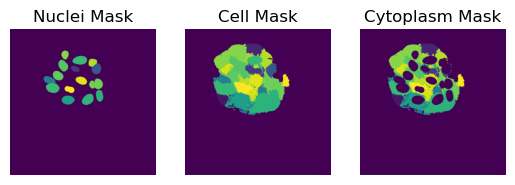

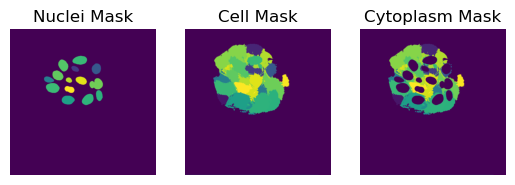

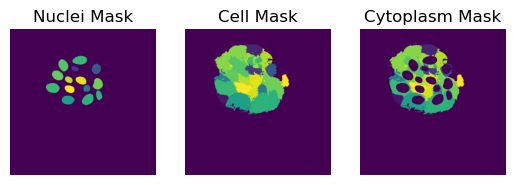

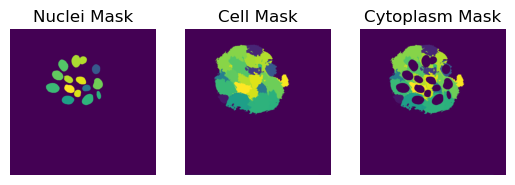

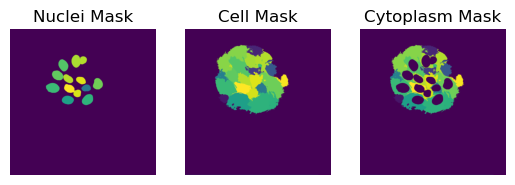

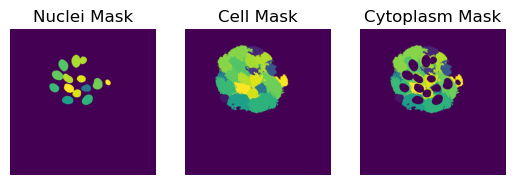

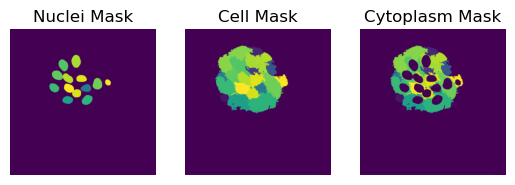

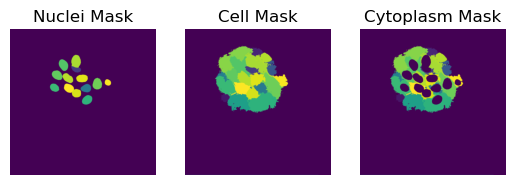

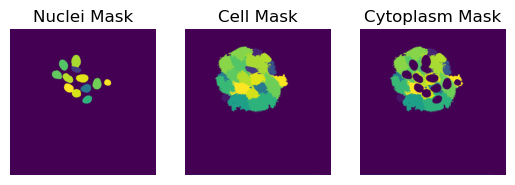

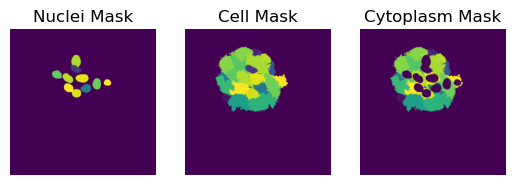

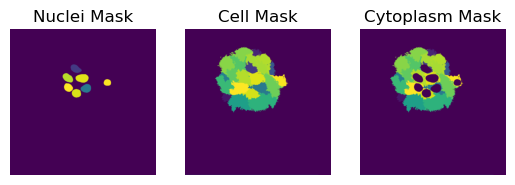

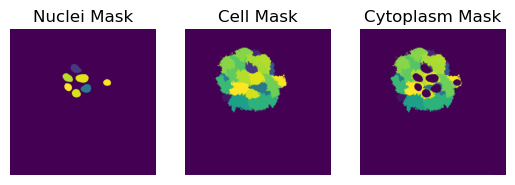

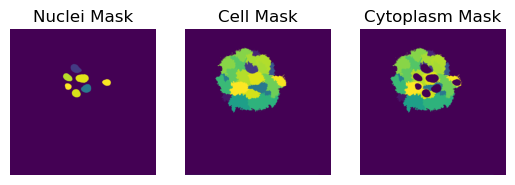

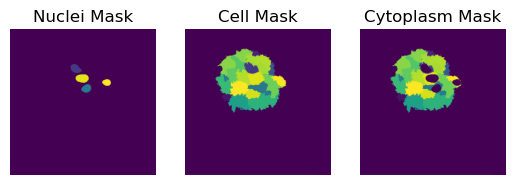

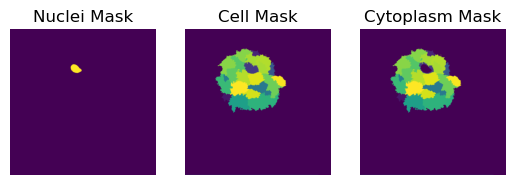

In [6]:
if in_notebook:
    for z in range(nuclei_masks.shape[0]):
        plt.subplot(1, 3, 1)
        plt.imshow(nuclei_masks[z])
        plt.title("Nuclei Mask")
        plt.axis("off")
        plt.subplot(1, 3, 2)
        plt.imshow(cell_masks[z])
        plt.title("Cell Mask")
        plt.axis("off")
        plt.subplot(1, 3, 3)
        plt.imshow(cytoplasm_masks[z])
        plt.title("Cytoplasm Mask")
        plt.axis("off")
        plt.show()